<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

# Прогнозирование стоимости автомобиля по характеристикам

* Работу выполнили Людмила Григорьева и Юлия Гиль
* Группа DSPR-28

# Содержание

1. [IMPORT, FUNCTIONS, SETUP](#1)
2. [DDATA & PRELIMINARY ANALYSIS](#2)
3. [EDA](#3) 
4. [NAÏVE MODEL](#4)
5. [MODEL IMPROVEMENTS](#5)
    * 
6. [SUBMISSION](#6)
7. [SUMMARY](#7)

<a id="1"></a>
# 1. Import, Functions, Setup

In [1]:
!pip3 install catboost

In [2]:
pip install pandas-profiling

Note: you may need to restart the kernel to use updated packages.


In [132]:
import numpy as np
import pandas as pd
import sys
import re
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings

from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
warnings.simplefilter('ignore')
sns.set()

In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.10 (default, May 19 2021, 11:01:55) 
Numpy        : 1.19.1


In [5]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [6]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

## Functions

In [7]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

## Setup

In [8]:
VERSION = 16
# подключил к ноутбуку внешний датасет
DIR_TRAIN = '../input/parsing-all-moscow-auto-ru-09-09-2020/'
DIR_TEST = '../input/sf-dst-car-price-prediction/'
VAL_SIZE = 0.20   # 20%

<a id="2"></a>
# 2. DATA & PRELIMINARY ANALYSIS

## Data Storage

In [9]:
!ls '../input'

ls: ../input: No such file or directory


In [10]:
# Подключение с Kaggle
""" train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv') # датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')"""

" train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv') # датасет для обучения модели\ntest = pd.read_csv(DIR_TEST+'test.csv')\nsample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')"

In [11]:
# Подключение при работе в Jupyter/Github
train = pd.read_csv('all_auto_ru_09_09_2020.csv') # подключение тестового train датасета
#train2 = pd.read_csv('autoru_res.csv', sep=",")
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [12]:
train.head()

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,99000.0,2020-09-02T14:04:21Z,NaN,100
3,Седан,AUDI,CACECB,бензин,1988.0,1.8 MT (90 л.с.),4.0,1989,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,65000.0,2020-08-23T17:40:09Z,NaN,100
4,Седан,AUDI,040001,бензин,1990.0,2.0 MT (101 л.с.),4.0,1991,SEDAN MECHANICAL 2.0,MECHANICAL,...,LEFT,NaN,3.0,DUPLICATE,True,NaN,100000.0,2020-09-08T09:22:07Z,NaN,100


In [13]:
test.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

In [15]:
test.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

## Web Data Extracting (auto.ru)

Посмотрим на список колонок, которые есть в test, но нет в подключенном train.

In [17]:
# Список колонок, которых нет в train
dif_list = list(set(test.columns).difference(train.columns))
print("Список колонок, которых нет в train, но есть в test:", dif_list)

# Посмотрим на данные в этих колонках
test[dif_list].sample(3)

Список колонок, которых нет в train, но есть в test: ['equipment_dict', 'image', 'model_info', 'parsing_unixtime', 'complectation_dict', 'priceCurrency', 'car_url', 'model_name', 'sell_id', 'vendor', 'super_gen']


,equipment_dict,image,model_info,parsing_unixtime,complectation_dict,priceCurrency,car_url,model_name,sell_id,vendor,super_gen
1615,"{""cruise-control"":true,""asr"":true,""tinted-glas...",https://autoru.naydex.net/ESooa9149/468b9eoMem...,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",1603232364,NaN,RUB,https://auto.ru/cars/used/sale/skoda/octavia/1...,OCTAVIA,1101235463,EUROPEAN,"{""id"":""20898378"",""displacement"":1798,""engine_t..."
25269,"{""front-centre-armrest"":true,""computer"":true,""...",https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,"{""code"":""POLO"",""name"":""Polo"",""ru_name"":""Поло"",...",1603220706,NaN,RUB,https://auto.ru/cars/used/sale/volkswagen/polo...,POLO,1100632330,EUROPEAN,"{""id"":""6214877"",""displacement"":1598,""engine_ty..."
34337,NaN,https://avatars.mds.yandex.net/get-autoru-vos/...,"{""code"":""LANCER"",""name"":""Lancer"",""ru_name"":""Ла...",1603680725,NaN,RUB,https://auto.ru/cars/used/sale/mitsubishi/lanc...,LANCER,1101369015,JAPANESE,"{""id"":""7846999"",""displacement"":1590,""engine_ty..."


In [18]:
# Посмотрим на колическтво уникальных значений
for item in dif_list:
    print(item, test[item].nunique())

equipment_dict 23705
image 34557
model_info 954
parsing_unixtime 34686
complectation_dict 2364
priceCurrency 1
car_url 34686
model_name 544
sell_id 34686
vendor 2
super_gen 5890


Выводы:
1. Из информации car_url видим, что данные собирались с сайта auto.ru, будем парсить данные оттуда
2. Следующие поля из test можно не парсить и удалить далее при анализе, т.к. они уникальны для каждой записи: car_url и priceCurrency, т.к. всего одно значение (RUB). Car_url оставим, чтоб можно было посмотреть информацию о машине.
3. Ограничимся для начала двумя вендорами: EUROPEAN, JAPANESE
4. Цену автомобиля собираем в RUB
5. Собираем информацию по полям: 'bodyType', 'brand', 'car_url', 'color', 'complectation_dict', 'description', 'engineDisplacement', 'enginePower', 'equipment_dict','fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name','name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency','productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration','vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС','Привод', 'Руль', 'Состояние', 'Таможня', 'sample', 'price'

# 3. EDA & Basic Data Cleaning

Проведем анализ данных, сделаем базовый препроцессинг данных.

### 3.1 Переименуем колонки с кириллицы на латиницу

In [19]:
# Переименуем test  колонки
test.rename(columns={"Привод": "drivetrain",
                     "Руль": "driveSide",
                     "Состояние": "condition",
                     "Владельцы": "ownersCount",
                     "ПТС": "tcp",
                     "Таможня": "customs",
                     "Владение": "ownershipTime",
                     "model_name": "model"}, inplace=True)

# Переименуем train  колонки
train.rename(columns={"Привод": "drivetrain",
                      "Руль": "driveSide",
                      "Состояние": "condition",
                      "Владельцы": "ownersCount",
                      "ПТС": "tcp",
                      "Таможня": "customs",
                      "Владение": "ownershipTime"}, inplace=True)

### 3.2 Предварительный анализ test данных

Посмотрим на данные в test, которые нужно предсказывать, на особенности данных.

In [20]:
#ProfileReport(test, title="Pandas Profiling Report for Test Dataset")

Выводы: во время последующего сбора данных и анализа обратить внимание на:
1. Есть пропуски в test данных - нужно попробовать заполнить
2. Представлено всего 12 брендов автомобилей
3. Признаки, которые выглядят бесполезными для моделирования - car_url (уникальный для каждой записи), priceCurrencly (одинаковый у всех)
4. Необходимо разобраться с признаками complectation_dict, description, equipment_dict, model_info, super_gen - посмотреть, можно ли извлечь доп. признаки
5. Condition - у всех "хорошее состояние", обратить внимание, если в train будут записи и другим состоянием, может влиять на выбросы по цене.
6. Customs - у всех "растоможетн", обратить внимание, если в train будут записи и другим состоянием, может влиять на выбросы по цене.

### 3.3 Сравним типы данных в test и train

Найдем расхождения в типах данных для train и test, устраним их до анализа данных.

In [21]:
# Создадим список с колонками, которые присутствуют и в train, и в test
cols_intersection = list(set(test.columns).intersection(train.columns))

In [22]:
# Проверим, в каких колонках типы данных различаются у train и test
cols_type_dif = []  # создаем список с колонками, в которых типы данных отличаются
print("Найдены расхождения в типах данных для:")

for col in cols_intersection:
    if type(test[col][0]) != type(train[col][0]):
        print(
            f"\t- колонки {col}: для train - {type(train[col][0])}, для test - {type(test[col][0])}")
        cols_type_dif.append(col)

Найдены расхождения в типах данных для:
	- колонки condition: для train - <class 'numpy.float64'>, для test - <class 'str'>
	- колонки ownersCount: для train - <class 'numpy.float64'>, для test - <class 'str'>
	- колонки numberOfDoors: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>
	- колонки customs: для train - <class 'numpy.bool_'>, для test - <class 'str'>
	- колонки modelDate: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>
	- колонки enginePower: для train - <class 'numpy.float64'>, для test - <class 'str'>


**ownersCount**

Количество владельцев автомобиля (1 - один, 2 - два, 3 - 3 и более).

In [23]:
print("Уникальные значения для train", train.ownersCount.unique())
print("Уникальные значения для test", test.ownersCount.unique())

Уникальные значения для train [ 3.  1.  2. nan]
Уникальные значения для test ['3 или более' '1\xa0владелец' '2\xa0владельца']


Преобразуем значения test в числовые (float).

In [24]:
# Создаем словать с кодировкой значений в числовые
ownersCount_dict = {"3 или более": 3.,
                    "1\xa0владелец": 1., "2\xa0владельца": 2.}
test['ownersCount'].replace(
    to_replace=ownersCount_dict, inplace=True)  # заменяем значения в соответствии со словарем

In [25]:
# Проверяем результаты преобразования
print("Уникальные значения для test", test.ownersCount.unique())

Уникальные значения для test [3. 1. 2.]


**enginePower**

Мощность л.с.

In [26]:
print("Пример значения для train", train.enginePower.sample(1).values)
print("Пример значения для test", test.enginePower.sample(1).values)

Пример значения для train [125.]
Пример значения для test ['170 N12']


Преобразуем значения test в числовые (float).

In [27]:
test.enginePower.nunique()

315

In [28]:
# Преобразовываем значения столбца, избавляемся от постфика N12
test['enginePower'] = test['enginePower'].apply(
    lambda x: float(x.split(" ")[0]))

In [29]:
# Посмотрим на результат преобразования
print("Пример значения для test", test.enginePower.sample(1).values)

Пример значения для test [140.]


**numberOfDoors**

Количество дверей.

In [30]:
print("Уникальные значения для train", train.numberOfDoors.unique())
print("Уникальные значения для test", test.numberOfDoors.unique())

Уникальные значения для train [ 4.  5.  3.  2. nan  0.]
Уникальные значения для test [5 4 2 3 0]


Значения аналогичны, целые числа, приведем в train к int.

In [31]:
# Конвертируем в int
train['numberOfDoors'] = train['numberOfDoors'].astype('Int64')

**customs**

Информация, растоможен ли автомобиль: 0 - не растоможен, 1 - растоможен.

In [32]:
print("Уникальные значения для train", train.customs.unique())
print("Уникальные значения для test", test.customs.unique())

Уникальные значения для train [ True]
Уникальные значения для test ['Растаможен']


Поскольку далее для моделирования нам понадобится числовая переменная, то сразу переведем в числовую 0 - не растоможен, 1 - растоможен, как для train, так и для test.

In [33]:
# Делаем преобразование значений в int (0 или 1)
train['customs'] = train['customs'].apply(lambda x: 1 if x == True else 0)
test['customs'] = test['customs'].apply(
    lambda x: 1 if x == "Растаможен" else 0)

**condition**

Состояние автомобиля: 0 - не требует ремонта , 1 - требует ремонта.

In [34]:
print("Уникальные значения для train", train.condition.unique())
print("Уникальные значения для test", test.condition.unique())

Уникальные значения для train [nan]
Уникальные значения для test ['Не требует ремонта']


Поскольку далее для моделирования нам понадобится числовая переменная, то сразу переведем в числовую 0 - требует ремонта , 1 - не требует ремонта, как для train, так и для test.

In [35]:
# Делаем преобразование значений в int (0 или 1)
train['condition'] = train['condition'].apply(lambda x: 0 if pd.isna(x) else 1)
test['condition'] = test['condition'].apply(
    lambda x: 0 if x == "Не требует ремонта" else 1)

**modelDate**

Год выпуска модели автомобиля.

In [36]:
print("Уникальные значения для train", train.modelDate.unique())
print("Уникальные значения для test", test.modelDate.unique())

Уникальные значения для train [1990. 1982. 1988. 1976. 1983. 1979. 1986. 1991. 1978. 1987. 1992. 1938.
 2010. 2014. 2000. 2016. 2004. 2012. 2008. 1996. 2003. 2015. 2011. 2007.
 1999. 1994. 2009. 2018. 2001. 1997. 2006. 2019. 2013. 2017. 2002. 2005.
 1980. 1984. 1998. 1966. 1975. 1937. 1936. 1949. 2020. 1995. 1981. 1972.
 1977. 1989. 1968. 1985. 1958. 1971. 1956. 1955. 1970. 1963. 1973. 1964.
 1957. 1993. 1960. 1927. 1908. 1932.   nan 1965. 1935. 1967. 1948. 1969.
 1934. 1974. 1950. 1961. 1904. 1959. 1951.]
Уникальные значения для test [2013 2017 2008 2009 2016 2012 2015 2010 2006 2000 2007 1994 2004 1999
 2005 1976 2001 1969 1996 1998 1989 1934 2014 2011 2018 1986 1997 1990
 2019 2002 1991 1987 1980 1982 1938 1988 2003 1983 1978 1979 1984 1992
 1995 1993 1985 1974 1966 1977 1981 1972 1968 1975 1949 1937 1936 1973
 1959 1958 2020 1965 1971 1904 1963 1955 1951 1960]


Годы - целые числа. Преобразуем train данные в int.

In [37]:
train['modelDate'] = train['modelDate'].astype('Int64')

**ownershipTime**

Вемя владения автомобилем. 

Несмотря на то, что тип данных совпадает, формат хранения информации в train и test отличается.

In [38]:
train['ownershipTime'] = train['ownershipTime'].fillna('no_data')

In [39]:
def months_to_sent(months):
    if months == 1:
        return f'{months} месяц'
    elif 2 <= months <= 4:
        return f'{months} месяца'
    return f'{months} месяцев'


def years_to_sent(years):
    if 11 <= years <= 14 or 5 <= years % 10 <= 9 or years % 10 == 0:
        return f'{years} лет'
    elif years % 10 == 1:
        return f'{years} год'
    elif 2 <= years % 10 <= 4:
        return f'{years} годa'


def tenure(row):
    """
    Функция, которая приводит содержимое ячейки train к тому же виду, как в test.
    Вход: строка series (строка колонки).
    Выход: возвращает вместо словаря информацию в виде "x лет y месяцев"
    """
    row = re.findall('\d+', str(row)) # находим все целые числа в строке
    if row != []:
        years = 2020 - (int(row[0])+1) # 2020, т.к. данные собраны в 2020 году
        months = 2 + (12 - int(row[1]))
        if years < 0:
            return months_to_sent(int(row[1]))
        elif years == 0 and months < 12:
            return months_to_sent(months)
        elif years >= 0 and months == 12:
            return years_to_sent(years + 1)
        elif years >= 0 and months > 12:
            return years_to_sent(years + 1)+' и '+months_to_sent(months - 12)
        elif years > 0 and months < 12:
            return years_to_sent(years)+' и '+months_to_sent(months)
        return None

train['ownershipTime'] = train['ownershipTime'].apply(tenure)

### 3.4 Совмещаем test и train для обработки и анализа

До совмещения test и train посмотрим, какие признаки можем извлечь из test/train, помимо колонок, которые в явном виде пересекаются между датафреймами.

In [40]:
# Список колонок, которых нет в train, но есть в test
dif_list_test = list(set(test.columns).difference(train.columns))
print("Список колонок, которых нет в train, но есть в test:", dif_list_test)

# Посмотрим на данные в этих колонках
print("\nTEST DF:")
test[dif_list_test].sample(3)

Список колонок, которых нет в train, но есть в test: ['equipment_dict', 'image', 'model_info', 'parsing_unixtime', 'complectation_dict', 'priceCurrency', 'car_url', 'sell_id', 'vendor', 'super_gen']

TEST DF:


,equipment_dict,image,model_info,parsing_unixtime,complectation_dict,priceCurrency,car_url,sell_id,vendor,super_gen
14567,"{""engine-proof"":true,""tinted-glass"":true,""airb...",https://avatars.mds.yandex.net/get-autoru-vos/...,"{""code"":""TIIDA"",""name"":""Tiida"",""ru_name"":""Тиид...",1603282739,"{""id"":""2433096"",""name"":""Comfort"",""available_op...",RUB,https://auto.ru/cars/used/sale/nissan/tiida/10...,1099521426,JAPANESE,"{""id"":""2433079"",""displacement"":1598,""engine_ty..."
31110,"{""engine-proof"":true,""cruise-control"":true,""as...",https://avatars.mds.yandex.net/get-autoru-vos/...,"{""code"":""YETI"",""name"":""Yeti"",""ru_name"":""Йети"",...",1603580666,NaN,RUB,https://auto.ru/cars/used/sale/skoda/yeti/1101...,1101353697,EUROPEAN,"{""id"":""20494707"",""displacement"":1968,""engine_t..."
33350,NaN,https://autoru.naydex.net/1xsMU7627/eea2057RFg...,"{""code"":""MR2"",""name"":""MR2"",""ru_name"":""МР 2"",""m...",1603613753,NaN,RUB,https://auto.ru/cars/used/sale/toyota/mr2/1101...,1101335589,JAPANESE,"{""id"":""8306237"",""displacement"":1998,""engine_ty..."


In [41]:
# Список колонок, которых нет в test, но есть в train
dif_list_train = list(set(train.columns).difference(test.columns))
print("Список колонок, которых нет в test, но есть в train:", dif_list_train)

# Посмотрим на данные в этих колонках
print("\nTRAIN DF:")
train[dif_list_train].sample(3)

Список колонок, которых нет в test, но есть в train: ['start_date', 'hidden', 'price', 'Комплектация']

TRAIN DF:


,start_date,hidden,price,Комплектация
29752,2020-04-07T23:07:02Z,NaN,530000.0,"{'id': '20162584', 'name': 'Comfort', 'availab..."
33600,2020-05-12T19:11:03Z,NaN,700000.0,{'id': '0'}
51493,2020-09-04T07:20:28Z,NaN,2123000.0,"{'id': '21436638', 'name': 'SE', 'available_op..."


Идеи для обогощений датасетов, чтобы получить общие данные для работы:
- [x] Train: добавить колонку vendor, можно создать словарик соответсвия brand-vendor
- [x] Train: model_name важная информация, нужно получить колонку. В train такая колонка есть - называется model. Унифицировать имена, привести к model (переименовать в test). Переименование добавлено выше в код, где переименовывались колонки.

Также дополнительно в TEST найдено:
- В признаке super_gen можно дополнительно доставть 1) acceleration (скорость разгона) 2) clearance_min 3) fuel_rate (расход топлива)
- В признаке equipment_dict лежит полезная информация про комплектацию автомобиля. Посмотреть, есть ли что-то похожее в Train.

**Добавляем vendor в train**

In [42]:
# Создаем словарь из вендоров по брендам
vendor_dict = test.groupby(['vendor'])['brand'].apply(lambda grp: list(grp.value_counts().index)).to_dict()
vendor_dict

{'EUROPEAN': ['BMW', 'VOLKSWAGEN', 'MERCEDES', 'AUDI', 'SKODA', 'VOLVO'],
 'JAPANESE': ['NISSAN', 'TOYOTA', 'MITSUBISHI', 'HONDA', 'INFINITI', 'LEXUS']}

In [43]:
# Список брендов, которых нет в test, но есть в train
dif_list_brands = list(set(train.brand.unique()).difference(test.brand.unique()))
print("Список колонок, которых нет в test, но есть в train:", dif_list_brands)

Список колонок, которых нет в test, но есть в train: ['RENAULT', 'SUBARU', 'DAEWOO', 'HYUNDAI', 'MAZDA', 'GREAT_WALL', 'LAND_ROVER', 'JAGUAR', 'PEUGEOT', 'MINI', 'GEELY', 'FORD', 'DODGE', 'CHEVROLET', 'SSANG_YONG', 'CHRYSLER', 'PORSCHE', 'SUZUKI', 'CITROEN', 'OPEL', 'CHERY', 'KIA', 'JEEP', 'CADILLAC']


In [44]:
# Добавим в словарь vendor_dict недостающие бренды по существующим ключам
eur_append = ['PORSCHE', 'LAND_ROVER', 'JAGUAR', 'MINI', 'RENAULT', 'OPEL', 'PEUGEOT', 'CITROEN']
jap_append = ['SUBARU', 'MAZDA', 'SUZUKI']

for brand in eur_append:
    vendor_dict['EUROPEAN'].append(brand) 
for brand in jap_append:
    vendor_dict['JAPANESE'].append(brand) 

In [45]:
# Добавляем новые ключи
vendor_dict.update({'AMERICAN': ['CHEVROLET', 'CHRYSLER', 'CADILLAC', 'JEEP', 'FORD', 'DODGE'], 
'ASIAN': ['HYUNDAI', 'DAEWOO', 'KIA', 'CHERY', 'SSANG_YONG', 'GEELY', 'GREAT_WALL']})

In [46]:
# Смотрим итоговый словарь
print(vendor_dict)

{'EUROPEAN': ['BMW', 'VOLKSWAGEN', 'MERCEDES', 'AUDI', 'SKODA', 'VOLVO', 'PORSCHE', 'LAND_ROVER', 'JAGUAR', 'MINI', 'RENAULT', 'OPEL', 'PEUGEOT', 'CITROEN'], 'JAPANESE': ['NISSAN', 'TOYOTA', 'MITSUBISHI', 'HONDA', 'INFINITI', 'LEXUS', 'SUBARU', 'MAZDA', 'SUZUKI'], 'AMERICAN': ['CHEVROLET', 'CHRYSLER', 'CADILLAC', 'JEEP', 'FORD', 'DODGE'], 'ASIAN': ['HYUNDAI', 'DAEWOO', 'KIA', 'CHERY', 'SSANG_YONG', 'GEELY', 'GREAT_WALL']}


In [47]:
# Создадим новый словарь для мапинга
new_map = {str(x): str(k) for k, v in vendor_dict.items() for x in v}

In [48]:
# Создаем признак vendor в train
train['vendor'] = train.brand.copy()
train['vendor'] = train['vendor'].map(new_map)

После завершения подготовительного этапа склеиваем два датафрейма.

In [49]:
# Для анализа склеиваем оба датафрейма по общим колонкам, добавляем признак sample
train['train'] = 1  # помечаем где у нас трейн
test['train'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения цены, мы его должны предсказать, поэтому пока просто заполняем нулями
test['price'] = 0
train['sell_id'] = 0  # поле понадобавиться для сабмита, оставляем

data = pd.concat([train, test], axis=0, join="inner", ignore_index=True)

In [50]:
# Посмотрим, что получилось
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124064 entries, 0 to 124063
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              124063 non-null  object 
 1   brand                 124064 non-null  object 
 2   color                 124064 non-null  object 
 3   fuelType              124064 non-null  object 
 4   modelDate             124063 non-null  object 
 5   name                  124063 non-null  object 
 6   numberOfDoors         124063 non-null  object 
 7   productionDate        124064 non-null  int64  
 8   vehicleConfiguration  124063 non-null  object 
 9   vehicleTransmission   124063 non-null  object 
 10  engineDisplacement    124063 non-null  object 
 11  enginePower           124063 non-null  float64
 12  description           120810 non-null  object 
 13  mileage               124064 non-null  int64  
 14  drivetrain            124063 non-null  object 
 15  

In [51]:
data.sample(3)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,condition,ownersCount,tcp,customs,ownershipTime,price,model,vendor,train,sell_id
16001,Седан,CHRYSLER,97948F,бензин,2004,2.7 AT (193 л.с.),4,2006,SEDAN AUTOMATIC 2.7,AUTOMATIC,...,0,2.0,DUPLICATE,1,None,550000.0,300C,AMERICAN,1,0
99110,седан,BMW,чёрный,бензин,2008,325xi 2.5 AT (218 л.с.) 4WD,4,2011,SEDAN AUTOMATIC 2.5,автоматическая,...,0,3.0,Дубликат,1,NaN,0.0,3ER,EUROPEAN,0,1045784376
6884,Седан,BMW,97948F,бензин,2002,525i 2.5 AT (218 л.с.),4,2005,SEDAN AUTOMATIC 525i,AUTOMATIC,...,0,3.0,ORIGINAL,1,None,470000.0,5ER,EUROPEAN,1,0


Проведем предварительный анализ данных.

In [52]:
# Запустим библиотеку для предварительного анализа данных
#ProfileReport(data, title="Pandas Profiling Report for Merged Test and Train Dataset")

Выводы:
1. Суммарно 124064 строки, 3.4% пропусков, есть дубликаты. Данные достаточно "чистые", пригодны для работы.
2. В датасете 26 признаков. Типы переменных: числовых - 6, категориальных - 20.
3. Идеи по очистке данных в колонках и вопросы для анализа данных:
    - bodyType - убрать верхний и нижний регистр, сократить кол-во категорий, убрать информацию о количестве дверей, тк есть отдельный признак numberOfDoors.
    - brand	- что такое GREAT_WALL?
    - color	- коды перевести в цвета
    - fuelType - разобраться, что такое универсал
    - vehicleTransmission - рус и англ варианты унифицировать
    - engineDisplacemen	- унифицировать в объем, привести 2.0 и 2.0 LTR к одному значению
    - numberOfDoors - разобраться с транспортом 0 дверей
    - driveSide	- рус и англ варианты унифицировать
    - tcp - рус и англ варианты унифицировать
    - description - кандидат на удаление, но можно извлечь новые признаки
    - ownershipTime - извлечь длитальность владения авто на момент сбора объявления
 
4. Признаки-кандидаты на удаление:
    - customs, condition - кандидаты на удаление, т.к. у всех сток одинаковые значений.
    - vehicleConfiguration - дублирует информацию из колонок vehicleTransmission, engineDisplacement, bodyType. Удалить признак после обработки пропусков.
    - name - дублирует информацию из колонок engineDisplacement, vehicleTransmission, enginePower, drivetrain. Удалить признак после обработки пропусков.
5. price - есть пропущенные значения, удалить строки из обучающей выборки.
6. Корреляционный анализ:
     - есть колинеарные признаки (productionDate - modelDate, mileage - modelDate/productionDate, ownersCount - modelDate/productionDat). Логично, что дата модели и дата производства связаны, также чем старше машина, тем больше пробег и тем большее количетсво владельцев авто)
     - связь с целевой переменной: наименьшая корреляция с признаком NumberofDoors.
7. Наибольшее количество пропусков в колонках ownershipCount, ownersCount. Можно попробовать предсказать количество, исходя из даты выпуска (т.к. признаки скоррелированы).

Создадим список, в который будем добавлять колонки-кандидаты на удаление из датасета.

In [53]:
# Создадим список и добавим колонки, которые планируем удалить по результатам предварительного анализа
cols_removal = ['customs', 'condition', 'vehicleConfiguration', 'name']

### 3.5 Базовая чистка данных

Проведем чистку и дополнительную подготовку данных, исходя из идей выводов выше (пункт 3).

- [x] color	- коды перевести в цвета
- [x] vehicleTransmission - рус и англ варианты унифицировать
- [x] driveSide	- рус и англ варианты унифицировать
- [x] tcp - рус и англ варианты унифицировать
- [x] bodyType - привести к нижнему регистру, т.к. часть данных указаны по разному.

**vehicleTransmission**

Информация про коробку передач.

In [54]:
data.vehicleTransmission.value_counts()

AUTOMATIC           49218
MECHANICAL          25264
автоматическая      19596
ROBOT                7871
механическая         7209
VARIATOR             7024
вариатор             3999
роботизированная     3882
Name: vehicleTransmission, dtype: int64

Посмотрим на значения на auto.ru. Все коробки делятся на автомат и механику. Автомат подразделяется на варианты.
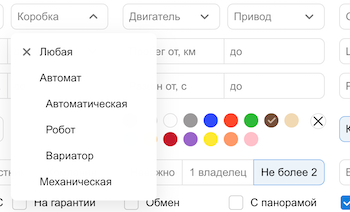

Создадим из данного признака два новых признака:
- коробка передач (автомат, механика)
- для автомата создадим признак (тип автомата).

In [55]:
# Создаем колонку transmission со значениями "автомат" и "механическая"
data['transmission'] = data.vehicleTransmission.copy()

data['transmission'].replace(['AUTOMATIC', 'ROBOT', 'VARIATOR',
                              'роботизированная', 'автоматическая', 'вариатор'], "автомат", inplace=True)
data['transmission'].replace(
    ['MECHANICAL', 'механическая'], "механическая", inplace=True)

In [56]:
# Создаем колонку automate_type со значениями 'робот', 'автоматическая', 'вариатор' или 0 для "механическая"

data['automaticType'] = data.vehicleTransmission.copy()

data['automaticType'].replace(
    ['AUTOMATIC', 'автоматическая'], "автоматическая", inplace=True)
data['automaticType'].replace(
    ['ROBOT', 'роботизированная', ], "робот", inplace=True)
data['automaticType'].replace(
    ['VARIATOR', 'вариатор'], "вариатор", inplace=True)
data['automaticType'].replace(['MECHANICAL', 'механическая'], 0, inplace=True)

In [57]:
# Проверим, какие значения получились
data['transmission'].unique()

array(['механическая', 'автомат', nan], dtype=object)

In [58]:
# Проверим, какие значения получились
data['automaticType'].unique()

array([0, 'автоматическая', 'робот', 'вариатор', nan], dtype=object)

In [59]:
# Добавляем в колонки на удаление обработаный признак
cols_removal.append('vehicleTransmission')

**color**

Цвет автомобиля.

In [60]:
# Посмотрим на представленные цвета
data.color.unique()

array(['040001', 'EE1D19', '0000CC', 'CACECB', '007F00', 'FAFBFB',
       '97948F', '22A0F8', '660099', '200204', 'C49648', 'DEA522',
       '4A2197', 'FFD600', 'FF8649', 'FFC0CB', 'синий', 'чёрный', 'серый',
       'коричневый', 'белый', 'пурпурный', 'бежевый', 'серебристый',
       'красный', 'зелёный', 'жёлтый', 'голубой', 'оранжевый',
       'фиолетовый', 'золотистый', 'розовый'], dtype=object)

In [61]:
# Создаем словать с кодировкой значений в цвета
color_dict = {'040001': 'чёрный', 'EE1D19': 'красный', '0000CC': 'синий', 'CACECB': 'серебристый', '007F00': 'зелёный',
              'FAFBFB': 'белый', '97948F': 'серый', '22A0F8': 'голубой', '660099': 'пурпурный', '200204': 'коричневый',
              'C49648': 'бежевый', 'DEA522': 'золотистый', '4A2197': 'фиолетовый', 'FFD600': 'жёлтый',
              'FF8649': 'оранжевый', 'FFC0CB': 'розовый'}

data['color'].replace(to_replace=color_dict, inplace=True)

In [62]:
# Проверяем результат
data.color.unique()

array(['чёрный', 'красный', 'синий', 'серебристый', 'зелёный', 'белый',
       'серый', 'голубой', 'пурпурный', 'коричневый', 'бежевый',
       'золотистый', 'фиолетовый', 'жёлтый', 'оранжевый', 'розовый'],
      dtype=object)

**driveSide**

Расположение руля

In [63]:
data.driveSide.unique()

array(['LEFT', 'RIGHT', 'Левый', 'Правый'], dtype=object)

In [64]:
# Заменим анлоязычные значения на русские
data['driveSide'] = data['driveSide'].map(
    {'RIGHT': 'Правый', 'LEFT': 'Левый', 'Правый': 'Правый', 'Левый': 'Левый'})

In [65]:
# уберем верхний регистр
data['driveSide'] = data['driveSide'].str.lower()

**tcp**

Оригинал ПТС

In [66]:
data.tcp.unique()

array(['ORIGINAL', 'DUPLICATE', nan, 'Оригинал', 'Дубликат'], dtype=object)

In [67]:
data[data.train == 0].tcp.head()

89378    Оригинал
89379    Оригинал
89380    Оригинал
89381    Оригинал
89382    Оригинал
Name: tcp, dtype: object

In [68]:
# Заменим анлоязычные значения на русские
data['tcp'] = data['tcp'].map(
    {'ORIGINAL': 'Оригинал', 'DUPLICATE': 'Дубликат', 'Оригинал': 'Оригинал', 'Дубликат': 'Дубликат'})

In [69]:
# уберем верхний регистр
data['tcp'] = data['tcp'].str.lower()

**bodyType**

Тип кузова.

In [70]:
data.bodyType.value_counts()

Внедорожник 5 дв.                  31885
Седан                              30593
седан                              13147
внедорожник 5 дв.                  12228
Хэтчбек 5 дв.                       8668
                                   ...  
Пикап Двойная кабина Double            1
Седан SRT                              1
Кабриолет JCW                          1
Пикап Полуторная кабина Rap Cab        1
Седан Axio                             1
Name: bodyType, Length: 192, dtype: int64

In [71]:
# Приведем значения к нижнему регистру, уберем ряд дубликатов в значениях

data['bodyType'] = data['bodyType'].apply(lambda x: str(x).lower())

### 3.6 Дубликаты

Определим количество дубликатов в данных в части train.

In [72]:
print("Количество дубликатов строк в train части датафрейма:",
      data[data.train == 1].duplicated().sum())

Количество дубликатов строк в train части датафрейма: 3577


In [73]:
# Удалим дубликаты из датасета
data.drop_duplicates(inplace=True)

### 3.7 Анализ пропусков

Посмотрим вцелом на наличие пустых значений и определим стратегию работы с ними.

In [74]:
def intitial_eda_checks(df, missing_percent):
    '''
    Функция принимает на вход датафрейм, а также заданный порог % пустых значений, который хотим обработать. 
    На выход выводит на экран информацию о сумме пустых значений для всех колонок, а также проце
    '''
    if df.isnull().sum().sum() > 0:
        mask_total = df.isnull().sum().sort_values(ascending=False)
        total = mask_total[mask_total > 0]

        mask_percent = df.isnull().mean().sort_values(ascending=False)
        percent = mask_percent[mask_percent > 0]

        series = mask_percent[mask_percent > missing_percent]
        columns = series.index.to_list()

        missing_data = pd.DataFrame(pd.concat(
            [total, round(percent*100, 2)], axis=1, keys=['Количество', '%']))
        print('Сумма и процент значений NaN:\n \n')
        display(missing_data)
    else:
        print('NaN значения не найдены.')

In [110]:
# Запускаем функцию вывода всех пустых значений
print("Пропуски для TEST+TRAIN датафрейов.\n")
intitial_eda_checks(data, 0)

Пропуски для TEST+TRAIN датафрейов.

Сумма и процент значений NaN:
 



,Количество,%
ownershipTimeMonths,91238,75.98
ownersCount,10535,8.77
description,3212,2.67


In [109]:
print("Пропуски для TEST датафрейма.\n")
intitial_eda_checks(data[data.train == 0], 0)

Пропуски для TEST датафрейма.

Сумма и процент значений NaN:
 



,Количество,%
ownershipTimeMonths,34686,100.0


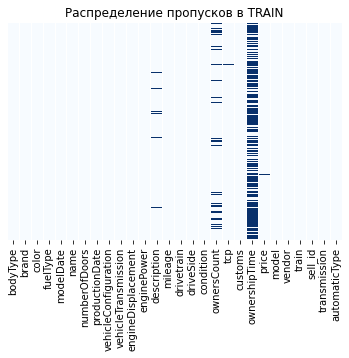

In [77]:
# Посмотрим, как распределены пропуски в части train
ax = plt.axes()
sns.heatmap(data[data.train == 1].isnull(), yticklabels=False, cbar=False, cmap='Blues')
ax.set_title('Распределение пропусков в TRAIN')
plt.show()

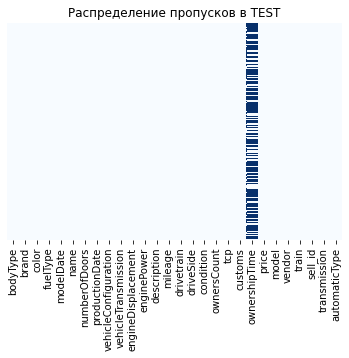

In [78]:
# Посмотрим, как распределены пропуски в части test
ax = plt.axes()
sns.heatmap(data[data.train == 0].isnull(), yticklabels=False, cbar=False, cmap='Blues')
ax.set_title('Распределение пропусков в TEST')
plt.show()

В таблице выведена информация по всем пустым значениям для всех столбцов основного рабочего датасета (data).

Выводы и стратегия обработки:
1. В 15 столбцах присутствуют пропуски.
2. Test:
    - [x] tcp: пропуск в одной записи, посмотреть на нее детально, попробовать восстановить или заполнить модой
    - [x] ownershipTime: много пропусков (около 65%), проанализировать с чем скоррелирован признак, попробовать заполнить. Если заполнить не получится, то возможно, удалить из признаков для моделирования.
3. Train + Test:
    - [ ] ownersCount (10554) - можно построить мапинг с медианой/модой по группам в зависимости от года выпуска авто. Заполним пропуски на этапе детального анализа признака.
    - [x] price (410) - значения с пропусками удалить из данных 
    - [x] tcp (310) - поисследовать пропуски и подумать над способами заполнения.
    - [x] есть ряд столбцов, где присутсвует ровно один пропуск. Проверить гипотезу, что пропуски находятся в одной и той же строке.
    - [x] description заполнить не удастся, колонка в таком виде, как есть, будет удаляться.

Займемся обработкой пропусков по описанной выше стратегии.

**price**

In [79]:
# Проверим, что price отсуствует именно в train данных и мы не затроним test
data[data.price.isnull() == True]['train'].value_counts()

1    410
Name: train, dtype: int64

In [80]:
# Удаляем строки с price = NAN
data.dropna(subset=['price'], inplace=True)

**Гипотеза, что NAN с одной строкой - это одна и та же запись**

In [81]:
data[data.modelDate.isnull() == True]

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,tcp,customs,ownershipTime,price,model,vendor,train,sell_id,transmission,automaticType
24624,nan,HONDA,серебристый,универсал,<NA>,NaN,<NA>,1989,NaN,NaN,...,оригинал,1,None,120000.0,CIVIC,JAPANESE,1,0,NaN,NaN


In [82]:
# Посмотрим, что за строка, где modelDate = NaN
print("Индекс строки к удалению:", data[data.modelDate.isnull() == True].index[0])

Индекс строки к удалению: 24624


Действительно, в одной строке очень много пропусков, при этом машина 1989, недорогая. Удаляем.

In [83]:
# Удаляем строку
data.drop([24624], inplace = True)

**tcp**

Проверим гипотезу, что:
- tcp пустой у новых машин
- tcp пустой там, где это дубликат.

In [84]:
# Посмотрим на пример таких данных
data[data.tcp.isnull() == True].sample(3)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,tcp,customs,ownershipTime,price,model,vendor,train,sell_id,transmission,automaticType
11755,внедорожник 5 дв.,CADILLAC,пурпурный,бензин,2019,2.0 AT (200 л.с.) 4WD,5,2020,ALLROAD_5_DOORS AUTOMATIC 2.0,AUTOMATIC,...,NaN,1,None,4180000.0,XT5,AMERICAN,1,0,автомат,автоматическая
17423,минивэн,CITROEN,белый,дизель,2016,2.0d AT (150 л.с.),5,2019,MINIVAN AUTOMATIC 2.0d,AUTOMATIC,...,NaN,1,None,2399900.0,SPACETOURER,EUROPEAN,1,0,автомат,автоматическая
49415,внедорожник 5 дв.,NISSAN,серый,бензин,2017,2.0 CVT (144 л.с.) 4WD,5,2020,ALLROAD_5_DOORS VARIATOR 2.0,VARIATOR,...,NaN,1,None,1881000.0,QASHQAI,JAPANESE,1,0,автомат,вариатор


In [85]:
# Сгруппируем данные по году выпуска и выведем медианный пробег и кол-во владельцев
data[data.tcp.isnull() == True].groupby('productionDate')['mileage', 'ownersCount'].median()

<ipython-input-85-f7ccf474eaa5>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data[data.tcp.isnull() == True].groupby('productionDate')['mileage', 'ownersCount'].median()


,mileage,ownersCount
productionDate,,
1999,276000,3.0
2018,0,NaN
2019,0,NaN
2020,0,NaN


Действительно, выглядит так, что NAN - для новых машин и одной машины с теста. 
Стратегия заполнения:
- для новых авто: новое значение "новая"
- для 10412 из test: попробуем "дубликат"

In [86]:
# Заполняем test значением дубликат
data.tcp.loc[data[(data.tcp.isnull() == True) & (data.train == 0)]['tcp'].index[0]] = 'дубликат'

/Users/yuliyagil/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [87]:
# Смотрим, какой mileage у оставшихся записей. Удостоверимся, что это авто без пробега
data[data.tcp.isnull() == True].mileage.value_counts()

0    348
Name: mileage, dtype: int64

In [88]:
# Заполняем значением "новое авто"
data.tcp.fillna('новое_авто', inplace = True)

In [89]:
# Проверяем, что получилось
data.tcp.value_counts()

оригинал      104833
дубликат       14895
новое_авто       348
Name: tcp, dtype: int64

**description**

In [90]:
# добавим колонку в список на удаление перед построением модели
cols_removal.append('description')

**OwnershipTime**



In [103]:
# Пока заполняем пропуски no_data, далее решаем, что сделать с признаком
data['ownershipTime'] = data['ownershipTime'].fillna('no_data')

### 3.8 Извлечение дополнительных признаков из данных

Посмотрим на данные и подумаем, какие дополнительные признаки можно "извлечь" из текущих данных без грубокого фиче инжениринга.

**ownershipTime**

Создадим на базе признака колонку, в которой поместим инфрмацию о количестве месяцев владения автомобилем.

In [92]:
def num_of_months(row):
    """
    Функция перевеодит формат данных "x лет y месяца(ев)" в количество месяцев.
    Вход: строка series.
    Выход: количество месяцев
    """
    if pd.notnull(row) and row != 'no_data':
        list_ownership = row.split()  # разделяем строку на список из месяца и лет
        if len(list_ownership) == 2:  # если содержится информация только про годы
            if list_ownership[1] in ['год', 'года', 'лет']:
                return int(list_ownership[0])*12
            return int(list_ownership[0])  # переводим год в месяцы
        # случай, когда содержится инфо только про месяц
        # прибавляем к годам*12 количетсво месяцев
        return int(list_ownership[0])*12 + int(list_ownership[3])

In [93]:
# Создаем новый столбец с количеством месяцев владения
data['ownershipTimeMonths'] = data['ownershipTime'].apply(num_of_months)

In [108]:
# Смотрим, что получилось
data[data.ownershipTime != 'no_data'][['ownershipTime', 'ownershipTimeMonths']].sample(5)

,ownershipTime,ownershipTimeMonths
20818,1 год и 11 месяцев,23.0
40286,3 месяца,3.0
48172,4 годa и 5 месяцев,53.0
7540,5 месяцев,5.0
29315,3 годa и 4 месяца,40.0


In [97]:
# Добавим исходную колонку в список на удаление перед построением модели
cols_removal.append('ownershipTime')

### Детальный анализ признаков

Список вопросов для детального анализа из предварительного анализа:
- [ ] fuelType - разобраться, что такое универсал
- [ ] engineDisplacemen	- разобраться, какие значения, унифицировать и/или сгенерировать новые признаки
- [ ] description - кандидат на удаление, но можно извлечь новые признаки
- [ ] ownershipTime - извлечь длительность владения авто на момент сбора объявления
- [ ] numberOfDoors - разобраться с транспортом 0 дверей

#### Группировка признаков на категориальные, бинарные и числовые

Посмотрим, какие признаки могут относиться к категориальным, бинарным, числовым.

In [111]:
# Посмотрим, сколько уникальных значений
data.nunique(dropna=False)

bodyType                  168
brand                      36
color                      16
fuelType                    5
modelDate                  78
name                     4774
numberOfDoors               5
productionDate             80
vehicleConfiguration     2023
vehicleTransmission         8
engineDisplacement        589
enginePower               398
description             99737
mileage                 24304
drivetrain                  3
driveSide                   2
condition                   1
ownersCount                 4
tcp                         3
customs                     1
ownershipTime             283
price                    8169
model                    1104
vendor                      4
train                       2
sell_id                 34687
transmission                2
automaticType               4
ownershipTimeMonths       280
dtype: int64

In [114]:
# Выведем пример признаков на экран
data.loc[5]

bodyType                                                            седан
brand                                                                AUDI
color                                                             зелёный
fuelType                                                           бензин
modelDate                                                            1990
name                                                    2.8 MT (174 л.с.)
numberOfDoors                                                           4
productionDate                                                       1993
vehicleConfiguration                                 SEDAN MECHANICAL 2.8
vehicleTransmission                                            MECHANICAL
engineDisplacement                                                    2.8
enginePower                                                           174
description             Хорошая комплектация: климат, эл. стекла, эл. ...
mileage                               

In [129]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120076 entries, 0 to 124063
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              120076 non-null  object 
 1   brand                 120076 non-null  object 
 2   color                 120076 non-null  object 
 3   fuelType              120076 non-null  object 
 4   modelDate             120076 non-null  object 
 5   name                  120076 non-null  object 
 6   numberOfDoors         120076 non-null  object 
 7   productionDate        120076 non-null  int64  
 8   vehicleConfiguration  120076 non-null  object 
 9   vehicleTransmission   120076 non-null  object 
 10  engineDisplacement    120076 non-null  object 
 11  enginePower           120076 non-null  float64
 12  description           116864 non-null  object 
 13  mileage               120076 non-null  int64  
 14  drivetrain            120076 non-null  object 
 15  

In [118]:
# Посмотрим, на колонки, которые планируем в последствие удалить, чтобы не включать их в анализ
print("Признаки для последующего удаления:", cols_removal)

Признаки для последующего удаления: ['customs', 'condition', 'vehicleConfiguration', 'name', 'vehicleTransmission', 'description', 'ownershipTime']


Исходя из количества уникальных значений, разделим все признаки на группу.

1. Категориальные признаки: 'bodyType', 'brand', 'color', 'fuelType', 'drivetrain', 'driveSide', 'tcp', 'model','vendor', 'transmission', 'automaticType'
2. Бинарные признаки: - 'customs', 'condition' (не алазируем, т.к. все данные представленны одним значением признака)
3. Числовые признаки: 'modelDate', 'numberOfDoors', 'productionDate', 'engineDisplacement', 'enginePower', 'mileage', 'ownersCount'
4. Даты: -
5. Служебный признак (не анализируем): 'train', 'sell_id'
6. Целевой: 'price'

In [135]:
# бинарные признаки
bin_cols = []

# категориальные переменные
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'drivetrain', 'driveSide', 'tcp', 'model',
            'engineDisplacement', 'vendor', 'transmission', 'automaticType', 'numberOfDoors', 'ownersCount']

# числовые переменные
num_cols = ['modelDate', 'productionDate',
            'enginePower', 'mileage']

# сервисные переменные
servis_cols = ['train', 'sell_id']

# целевая переменная
target_col = ['price']

all_cols = bin_cols + cat_cols + num_cols + servis_cols + target_col

print("Кол-во столбцов, для дальнейшей работы после предварительного анализа:", len(all_cols))

Кол-во столбцов, для дальнейшей работы после предварительного анализа: 21


#### Числовые переменные: распределение, корреляционный анализ, определение значимости

###### Распределние численных признаков.

Диаграмы распределения числовых признаков


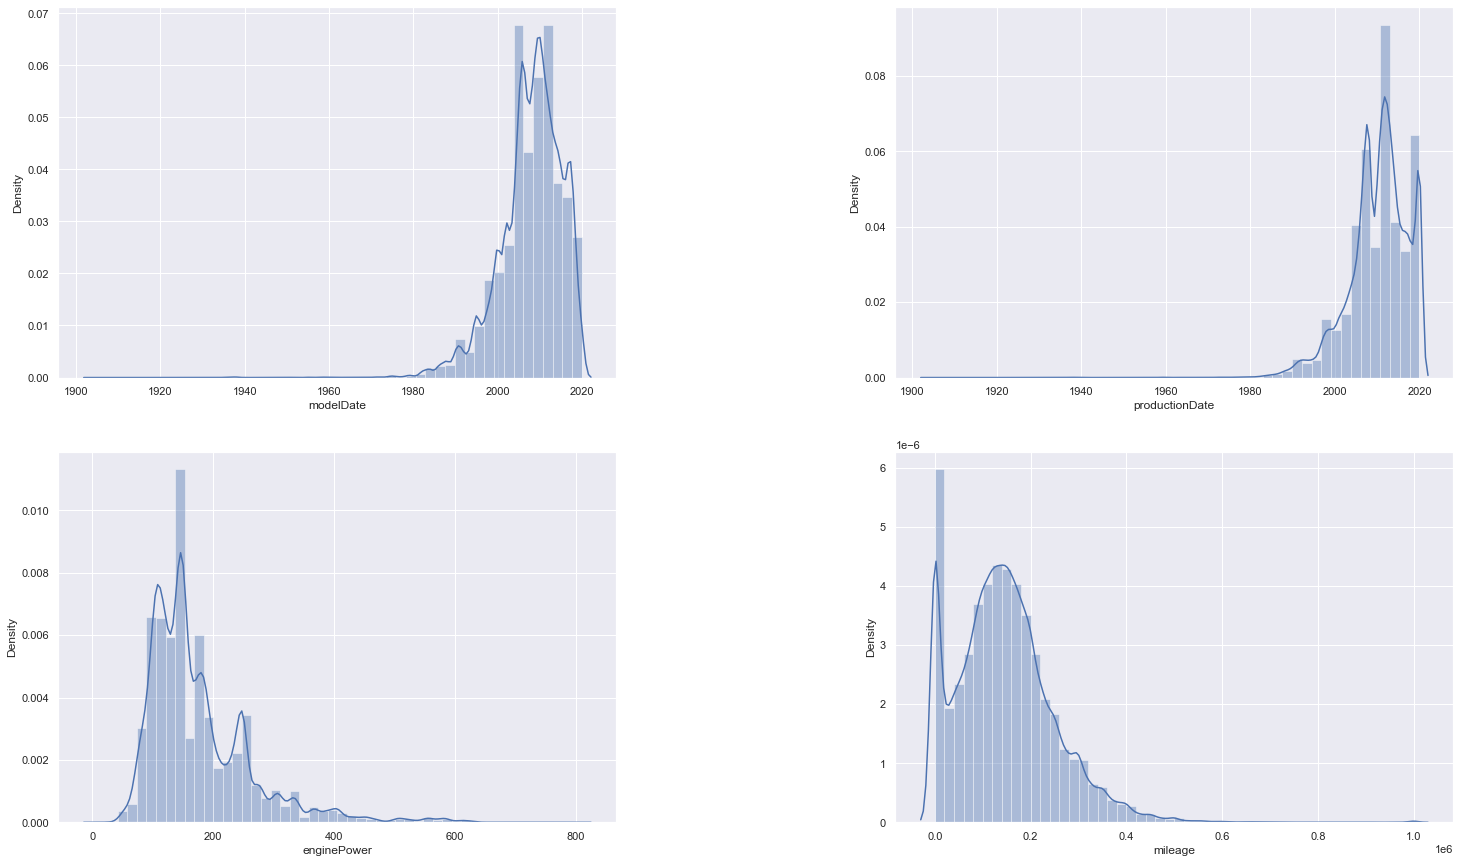

In [151]:
# Построим распределение основных числовых признаков

print("Диаграмы распределения числовых признаков")

fig, axes = plt.subplots(2, 2, figsize=(25, 15))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()
i = 0

for col in num_cols:
    sns.distplot(data[col], ax=axes[i])
    i = i + 1

Выводы:

1. После построения гистограмм стало очевидно, что распределения основных числовых переменных имеют тяжёлый левый или правый хвост. Для того, чтобы сделать распределение данных переменных более нормальным, можно работать с логарифмированными величинами этих переменных. 
2. Распределние modelDate, productionDate очень схожи, проверить на признаки на мультиколлинеарность во время корреляционного анализа.

###### Взаимосвязь признаков с таргетом

In [ ]:
# Построем boxplot’ы для численных переменных.
print("Диаграмы boxplot для распределения числовых признаков и целевой переменной")

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()

for i in range(len(num_cols)):
    sns.boxplot(x='price', y=num_cols[i], data=data[data['train'] == 1],
                orient='v', ax=axes[i], showfliers=False)

Диаграмы boxplot для распределения числовых признаков и целевой переменной


Выводы:

1. 

###### Корреляционный анализ.

Оценим корреляцию Пирсона для непрерывных переменных. Cильная корреляция между переменными вредна для линейных моделей из-за неустойчивости полученных оценок.

### Анализ выбросов


### Анализ взаимосвязи признаков между собой


### Анализ взаимосвязи признаков с таргетом

### Выводы и идеи по генерации новых признаков

In [ ]:
train.dropna(subset=['productionDate', 'mileage'], inplace=True)
train.dropna(subset=['price'], inplace=True)

In [ ]:
# для baseline просто возьму пару схожих признаков без полной обработки
columns = ['bodyType', 'brand', 'productionDate',
           'engineDisplacement', 'mileage']
df_train = train[columns]
df_test = test[columns]

In [ ]:
y = train['price']

### Label Encoding

In [ ]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем

In [ ]:
for colum in ['bodyType', 'brand', 'engineDisplacement']:
    data[colum] = data[colum].astype('category').cat.codes

In [ ]:
data

In [ ]:
X = data.query('sample == 1').drop(['sample'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)

## Train Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# 5. Model 1. Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.




In [ ]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [ ]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(
    tmp_train.groupby('engineDisplacement')['price'].median())

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

# 6. Model 2 : CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Fit

In [ ]:
model = CatBoostRegressor(iterations=5000,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                          )
model.fit(X_train, y_train,
          # cat_features=cat_features_ids,
          eval_set=(X_test, y_test),
          verbose_eval=0,
          use_best_model=True,
          # plot=True
          )

model.save_model('catboost_single_model_baseline.model')

In [ ]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Вот так просто со старта, даже не трогая сами данные и не подбирая настройки catboosta, получаем модель с уровнем ошибки в 18%!

### Log Traget
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    
В принциепе мы можем использовать любое приобразование на целевую переменную. Например деление на курс доллара, евро или гречки :) в дату сбора данных, смотрим дату парсинга в тесте в **parsing_unixtime**

In [ ]:
np.log(y_train)

In [ ]:
model = CatBoostRegressor(iterations=5000,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                          )
model.fit(X_train, np.log(y_train),
          # cat_features=cat_features_ids,
          eval_set=(X_test, np.log(y_test)),
          verbose_eval=0,
          use_best_model=True,
          # plot=True
          )

model.save_model('catboost_single_model_2_baseline.model')

In [ ]:
predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(X_sub))

In [ ]:
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Как видим точность возросла до 15%, а что будет на ЛБ?

# Model 3. Lazypredict


In [ ]:
pip install lazypredict

In [ ]:
import lazypredict

In [ ]:
from lazypredict.Supervised import LazyRegressor

#reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
#models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# print(models)

# 7. Submission

In [ ]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

В итоге получили **MAPE 27%** на ЛБ!

Большая разница в ошибке может указывать на то что тест и трейн имеют различия по выборке или то что данные в трейне могли уже устареть и их нужно обновлять.

# What's next?
Или что еще можно сделать, чтоб улучшить результат:

* Спарсить свежие данные 
* Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
* Сгенерировать новые признаки
* Попробовать подобрать параметры модели
* Попробовать другие алгоритмы и библиотеки ML
* Сделать Ансамбль моделей, Blending, Stacking

Подробный чек лист: https://docs.google.com/spreadsheets/d/1I_ErM3U0Cs7Rs1obyZbIEGtVn-H47pHNCi4xdDgUmXY/edit?usp=sharing